In [ ]:
#cargamos desde kaggle con el usuario y llave
!pip -q install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/joniarroba/noshowappointments", data_dir="/content/data")


Skipping, found downloaded files in "/content/data/noshowappointments" (use force=True to force download)


In [ ]:
!ls -lh /content/data/noshowappointments

import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", 120)

CSV_PATH = "/content/data/noshowappointments/KaggleV2-May-2016.csv"

# Fuerza tipos seguros para evitar convertir IDs a float
dtype_map = {
    "PatientId": "string",       # evita float -> pérdida de precisión
    "AppointmentID": "Int64",    # entero nullable de pandas
    "Gender": "string",
    "Neighbourhood": "string",
    "No-show": "string"
}

raw = pd.read_csv(CSV_PATH, dtype=dtype_map, low_memory=False)

# Normaliza encabezados
raw.columns = [c.lower() for c in raw.columns]

# revisemos
raw.head(3), raw.shape, raw.dtypes


total 11M
-rw-r--r-- 1 root root 11M Dec 10 00:24 KaggleV2-May-2016.csv


(         patientid  appointmentid gender          scheduledday  \
 0   29872499824296        5642903      F  2016-04-29T18:38:08Z   
 1  558997776694438        5642503      M  2016-04-29T16:08:27Z   
 2    4262962299951        5642549      F  2016-04-29T16:19:04Z   
 
          appointmentday  age    neighbourhood  scholarship  hipertension  \
 0  2016-04-29T00:00:00Z   62  JARDIM DA PENHA            0             1   
 1  2016-04-29T00:00:00Z   56  JARDIM DA PENHA            0             0   
 2  2016-04-29T00:00:00Z   62    MATA DA PRAIA            0             0   
 
    diabetes  alcoholism  handcap  sms_received no-show  
 0         0           0        0             0      No  
 1         0           0        0             0      No  
 2         0           0        0             0      No  ,
 (110527, 14),
 patientid         string[python]
 appointmentid              Int64
 gender            string[python]
 scheduledday              object
 appointmentday            object
 a

In [ ]:
for c in ["scholarship","hipertension","diabetes","alcoholism","sms_received"]:
    print(c, sorted(raw[c].unique())[:5])

print("no-show uniques:", raw["no-show"].unique())


scholarship [np.int64(0), np.int64(1)]
hipertension [np.int64(0), np.int64(1)]
diabetes [np.int64(0), np.int64(1)]
alcoholism [np.int64(0), np.int64(1)]
sms_received [np.int64(0), np.int64(1)]
no-show uniques: <StringArray>
['No', 'Yes']
Length: 2, dtype: string


In [ ]:
diccionario_original = pd.DataFrame([
    ("patientid",      "ID del paciente (numérico grande; identificador)",               "numérica (ID)"),
    ("appointmentid",  "ID de la cita (identificador único)",                            "numérica (ID)"),
    ("gender",         "Sexo del paciente: 'F'/'M'",                                      "categórica (binaria)"),
    ("scheduledday",   "Fecha/hora en que se agendó la cita (ISO-UTC)",                  "fecha-tiempo"),
    ("appointmentday", "Fecha de la cita (ISO-UTC; hora usualmente 00:00)",              "fecha-tiempo"),
    ("age",            "Edad en años (valores negativos son anomalías)",                 "numérica (continua)"),
    ("neighbourhood",  "Barrio / zona de residencia",                                     "categórica"),
    ("scholarship",    "Indicador de programa social/subsidio (0/1)",                    "dummie (0/1)"),
    ("hipertension",   "Indicador de hipertensión (0/1)",                                "dummie (0/1)"),
    ("diabetes",       "Indicador de diabetes (0/1)",                                    "dummie (0/1)"),
    ("alcoholism",     "Indicador de alcoholismo (0/1)",                                 "dummie (0/1)"),
    ("handcap",        "Grado de discapacidad (0–4; no estrictamente binaria)",          "ordinal (0–4)"),
    ("sms_received",   "Indicador de SMS de recordatorio recibido (0/1)",                "dummie (0/1)"),
    ("no-show",        "Etiqueta: 'Yes' = NO asistió; 'No' = asistió",                   "categórica (binaria texto)")
], columns=["variable","descripcion","tipo_esperado"])

# dtype y #faltantes/únicos
aux = []
for c in raw.columns:
    aux.append({
        "variable": c,
        "dtype_pandas": str(raw[c].dtype),
        "n_missing": int(raw[c].isna().sum()),
        "pct_missing": raw[c].isna().mean().round(4),
        "n_unique": int(raw[c].nunique())
    })
estructura = pd.DataFrame(aux)

dicc_original_completo = diccionario_original.merge(estructura, on="variable", how="right")
dicc_original_completo = dicc_original_completo[["variable","descripcion","tipo_esperado","dtype_pandas","n_unique","n_missing","pct_missing"]]

dicc_original_completo


,variable,descripcion,tipo_esperado,dtype_pandas,n_unique,n_missing,pct_missing
0,patientid,ID del paciente (numérico grande; identificador),numérica (ID),string,62299,0,0.0
1,appointmentid,ID de la cita (identificador único),numérica (ID),Int64,110527,0,0.0
2,gender,Sexo del paciente: 'F'/'M',categórica (binaria),string,2,0,0.0
3,scheduledday,Fecha/hora en que se agendó la cita (ISO-UTC),fecha-tiempo,object,103549,0,0.0
4,appointmentday,Fecha de la cita (ISO-UTC; hora usualmente 00:00),fecha-tiempo,object,27,0,0.0
5,age,Edad en años (valores negativos son anomalías),numérica (continua),int64,104,0,0.0
6,neighbourhood,Barrio / zona de residencia,categórica,string,81,0,0.0
7,scholarship,Indicador de programa social/subsidio (0/1),dummie (0/1),int64,2,0,0.0
8,hipertension,Indicador de hipertensión (0/1),dummie (0/1),int64,2,0,0.0
9,diabetes,Indicador de diabetes (0/1),dummie (0/1),int64,2,0,0.0


In [ ]:
# Limpieza y variables para modelado

# Partimos del DataFrame 'raw')
df = raw.copy()

# 2.1 Etiquetamos (1 = no asistió; 0 = asistió)
df["no_show"] = (df["no-show"].str.upper() == "YES").astype("int8")

# 2.2 Parseo seguro de fechas a datetime (timezone-aware)
df["scheduledday"]   = pd.to_datetime(df["scheduledday"],   utc=True, errors="coerce")
df["appointmentday"] = pd.to_datetime(df["appointmentday"], utc=True, errors="coerce")

# Nota: 'sched_hour' y 'appt_weekday' se derivan en UTC (timestamps terminan en 'Z').
# Si se requiere hora local, convertir con .dt.tz_convert("America/Sao_Paulo")
# y reconstruir la fecha local de cita. (No lo cambiamos aquí.)


# 2.3 Derivadas de tiempo
# Normaliza a medianoche para operar en días calendario (evita .dt.date -> object)
sched_norm = df["scheduledday"].dt.normalize()
appt_norm  = df["appointmentday"].dt.normalize()

wait_days_raw = (appt_norm - sched_norm).dt.days           # Timedelta -> .dt.days
df["wait_days"]    = np.clip(wait_days_raw, 0, 365)        # recorte prudente (0..365)
df["appt_weekday"] = df["appointmentday"].dt.day_name()    # día de la semana de la cita
df["sched_hour"]   = df["scheduledday"].dt.hour            # hora a la que se agendó

# 2.4 Diagnóstico antes de filtrar
neg_age_cnt  = int((df["age"] < 0).sum())
neg_wait_cnt = int((wait_days_raw < 0).sum())
dup_cnt      = int(df.duplicated().sum())
print(f"Edades negativas                   : {neg_age_cnt}")
print(f"Esperas negativas (antes del clip) : {neg_wait_cnt}")
print(f"Duplicados exactos (todas columnas): {dup_cnt}")

# 2.5 Filtrado básico y selección de columnas del modelo
n_before = df.shape[0]
df = df[df["age"] >= 0].copy()         # quita edades negativas
df = df.drop_duplicates()              # quita filas idénticas
n_after = df.shape[0]
print(f"Filtrados: {n_before - n_after} filas (edad negativa y/o duplicados)")

cols_modelo = [
    "no_show","age","gender","neighbourhood","scholarship","hipertension",
    "diabetes","alcoholism","handcap","sms_received",
    "wait_days","appt_weekday","sched_hour"
]
df_modelo = df[cols_modelo].copy()

print("Tamaño tras limpieza/modelo:", df_modelo.shape)
df_modelo.head(3)




Edades negativas                   : 1
Esperas negativas (antes del clip) : 5
Duplicados exactos (todas columnas): 0
Filtrados: 1 filas (edad negativa y/o duplicados)
Tamaño tras limpieza/modelo: (110526, 13)


,no_show,age,gender,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,wait_days,appt_weekday,sched_hour
0,0,62,F,JARDIM DA PENHA,0,1,0,0,0,0,0,Friday,18
1,0,56,M,JARDIM DA PENHA,0,0,0,0,0,0,0,Friday,16
2,0,62,F,MATA DA PRAIA,0,0,0,0,0,0,0,Friday,16


In [ ]:
# Diccionario para el dataset de modelado
diccionario_modelo = pd.DataFrame([
    ("no_show",      "Etiqueta binaria (1=No asistió; 0=Asistió)",                  "objetivo", "dummie (0/1)"),
    ("age",          "Edad en años (>=0)",                                          "feature",  "numérica (continua)"),
    ("gender",       "Sexo 'F'/'M'",                                                "feature",  "categórica"),
    ("neighbourhood","Barrio / zona",                                               "feature",  "categórica"),
    ("scholarship",  "Indicador de subsidio (0/1)",                                  "feature",  "dummie (0/1)"),
    ("hipertension", "Hipertensión (0/1)",                                          "feature",  "dummie (0/1)"),
    ("diabetes",     "Diabetes (0/1)",                                              "feature",  "dummie (0/1)"),
    ("alcoholism",   "Alcoholismo (0/1)",                                           "feature",  "dummie (0/1)"),
    ("handcap",      "Grado de discapacidad (0–4)",                                 "feature",  "ordinal (0–4)"),
    ("sms_received", "Recibió SMS recordatorio (0/1)",                              "feature",  "dummie (0/1)"),
    ("wait_days",    "Días entre agendamiento y cita (0–365, recortado)",           "feature",  "numérica (continua)"),
    ("appt_weekday", "Día de la semana de la cita (Mon..Sun)",                      "feature",  "categórica"),
    ("sched_hour",   "Hora del día en que se agendó (0–23)",                        "feature",  "numérica (discreta)"),
], columns=["variable","descripcion","rol","tipo_esperado"])

aux = []
for c in df_modelo.columns:
    aux.append({
        "variable": c,
        "dtype_pandas": str(df_modelo[c].dtype),
        "n_unique": int(df_modelo[c].nunique()),
        "n_missing": int(df_modelo[c].isna().sum()),
        "pct_missing": round(df_modelo[c].isna().mean(), 4),
    })
estructura = pd.DataFrame(aux)

dicc_modelo = diccionario_modelo.merge(estructura, on="variable", how="right")[
    ["variable","descripcion","rol","tipo_esperado","dtype_pandas","n_unique","n_missing","pct_missing"]
]

print("Diccionario para el modelo:")
dicc_modelo


Diccionario para el modelo:


,variable,descripcion,rol,tipo_esperado,dtype_pandas,n_unique,n_missing,pct_missing
0,no_show,Etiqueta binaria (1=No asistió; 0=Asistió),objetivo,dummie (0/1),int8,2,0,0.0
1,age,Edad en años (>=0),feature,numérica (continua),int64,103,0,0.0
2,gender,Sexo 'F'/'M',feature,categórica,string,2,0,0.0
3,neighbourhood,Barrio / zona,feature,categórica,string,81,0,0.0
4,scholarship,Indicador de subsidio (0/1),feature,dummie (0/1),int64,2,0,0.0
5,hipertension,Hipertensión (0/1),feature,dummie (0/1),int64,2,0,0.0
6,diabetes,Diabetes (0/1),feature,dummie (0/1),int64,2,0,0.0
7,alcoholism,Alcoholismo (0/1),feature,dummie (0/1),int64,2,0,0.0
8,handcap,Grado de discapacidad (0–4),feature,ordinal (0–4),int64,5,0,0.0
9,sms_received,Recibió SMS recordatorio (0/1),feature,dummie (0/1),int64,2,0,0.0


In [ ]:
# PASO 4 — Tamaño (antes/después) y balance de clases
n_raw  = raw.shape[0]
n_final = df_modelo.shape[0]
print(f"Observaciones originales : {n_raw}")
print(f"Observaciones finales    : {n_final}")
print(f"Removidas (limpieza)     : {n_raw - n_final}")

balance = df_modelo["no_show"].value_counts().rename({0:"Asistió",1:"No-show"}).to_frame("conteo")
balance["proporcion"] = (balance["conteo"] / balance["conteo"].sum()).round(4)
balance


Observaciones originales : 110527
Observaciones finales    : 110526
Removidas (limpieza)     : 1


,conteo,proporcion
no_show,,
Asistió,88207,0.7981
No-show,22319,0.2019


In [ ]:
# Define grupos de variables
numericas   = ["age","wait_days","sched_hour","handcap"]  # handcap es ordinal 0–4, pero la describimos como numérica
dummies     = ["scholarship","hipertension","diabetes","alcoholism","sms_received","no_show"]
categoricas = ["gender","appt_weekday","neighbourhood"]

# (1) Numéricas: media, sd, min, p25, p50, p75, max
desc_num = df_modelo[numericas].describe(percentiles=[.25,.5,.75]).T
desc_num = desc_num.rename(columns={
    "count":"N","mean":"media","std":"sd","min":"min","25%":"p25","50%":"p50","75%":"p75","max":"max"
})[["N","media","sd","min","p25","p50","p75","max"]].round(3)

# Dummies: proporción de 1s + chequeo de binariedad
def resumen_dummy(s):
    vals = set(s.dropna().unique())
    binaria = vals.issubset({0,1})
    return pd.Series({
        "binaria_0_1": binaria,
        "prop_1": round(float(s.mean()), 4),
        "N": int(s.notna().sum())
    })

desc_dum = pd.concat([resumen_dummy(df_modelo[c]) for c in dummies], axis=1).T
desc_dum.index.name = "variable"
desc_dum = desc_dum[["N","binaria_0_1","prop_1"]]

#(3) Categóricas: nº categorías y Top-10 categorías
rows = []
for c in categoricas:
    vc = df_modelo[c].value_counts(dropna=False)
    rows.append({
        "variable": c,
        "n_categorias": int(vc.shape[0]),
        "top10": ", ".join([f"{idx} ({int(cnt)})" for idx, cnt in vc.head(10).items()])
    })
desc_cat = pd.DataFrame(rows)[["variable","n_categorias","top10"]]

# (4) Cruces útiles para el informe
# Tasa de no-show por día de la semana
rate_by_day = (df_modelo.groupby("appt_weekday")["no_show"]
               .mean().sort_values(ascending=False).rename("tasa_no_show").to_frame().round(3))

# Tasa de no-show por recepción de SMS
rate_by_sms = (df_modelo.groupby("sms_received")["no_show"]
               .mean().rename({0:"sin_sms",1:"con_sms"}).to_frame().T.round(3))

# Conteo por género
cnt_gender = df_modelo["gender"].value_counts().to_frame("conteo")

# (5) Exporta a CSV para adjuntar al reporte
outdir = "/content"
paths = {
    "descriptivas_numericas.csv": desc_num,
    "descriptivas_dummies.csv":   desc_dum,
    "descriptivas_categoricas.csv": desc_cat,
    "no_show_por_dia.csv":        rate_by_day,
    "no_show_por_sms.csv":        rate_by_sms,
    "conteo_genero.csv":          cnt_gender,
}
for name, tbl in paths.items():
    tbl.to_csv(f"{outdir}/{name}")
list(paths.keys())


['descriptivas_numericas.csv',
 'descriptivas_dummies.csv',
 'descriptivas_categoricas.csv',
 'no_show_por_dia.csv',
 'no_show_por_sms.csv',
 'conteo_genero.csv']

In [ ]:
# PASO 5bis — EDA gráfica

import matplotlib.pyplot as plt

# Asegura que df_modelo existe
assert 'df_modelo' in globals(), "df_modelo no está definido. Ejecuta el PASO 2."

# Define listas si no existen
try:
    numericas
except NameError:
    numericas   = ["age","wait_days","sched_hour","handcap"]  # handcap es ordinal (0–4), lo tratamos como numérica para EDA
try:
    dummies
except NameError:
    dummies     = ["scholarship","hipertension","diabetes","alcoholism","sms_received"]
try:
    categoricas
except NameError:
    categoricas = ["gender","appt_weekday","neighbourhood"]


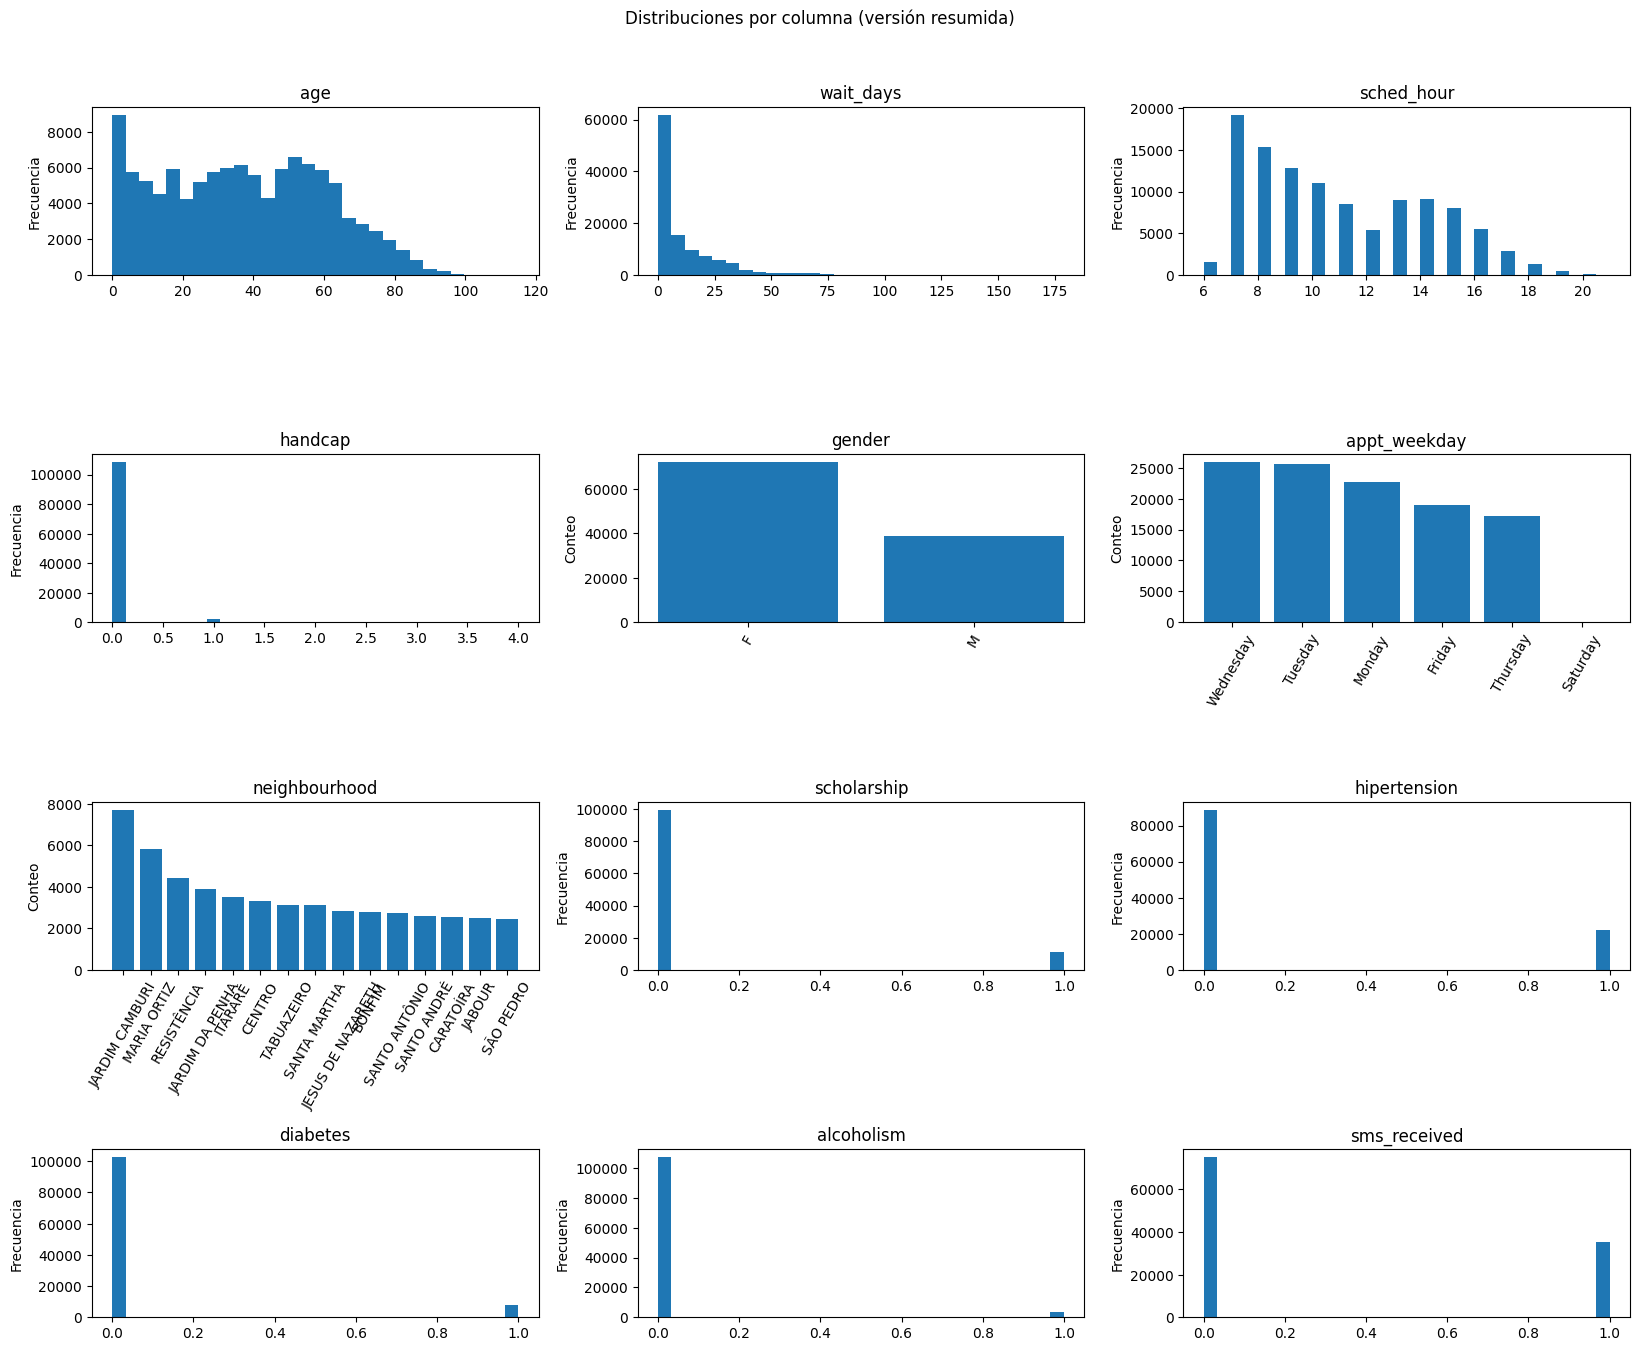

In [ ]:
from math import ceil

# Usa los grupos que ya definimos antes
numericas   = ["age","wait_days","sched_hour","handcap"]  # handcap es ordinal, la graficamos como numérica
categoricas = ["gender","appt_weekday","neighbourhood"]   # (neighbourhood tiene muchas categorías)
dummies     = ["scholarship","hipertension","diabetes","alcoholism","sms_received"]

def plot_per_column_distribution(df, num_cols, cat_cols, dum_cols=None, max_cat=15):
    cols = list(num_cols) + list(cat_cols) + list(dum_cols or [])
    cols = [c for c in cols if c in df.columns and c != "no_show"]
    n = len(cols)
    ncols = 3
    nrows = ceil(n / ncols) if n > 0 else 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.5*ncols, 3.3*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, c in enumerate(cols):
        ax = axes[i]
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            ax.hist(s.dropna(), bins=30)
            ax.set_ylabel("Frecuencia")
        else:
            vc = s.value_counts(dropna=False)
            # limitar categorías largas
            vc = vc.head(max_cat)
            ax.bar(vc.index.astype(str), vc.values)
            ax.tick_params(axis='x', rotation=60)
            ax.set_ylabel("Conteo")
        ax.set_title(c)
    # ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    fig.suptitle("Distribuciones por columna (versión resumida)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_per_column_distribution(df_modelo, numericas, categoricas, dummies, max_cat=15)


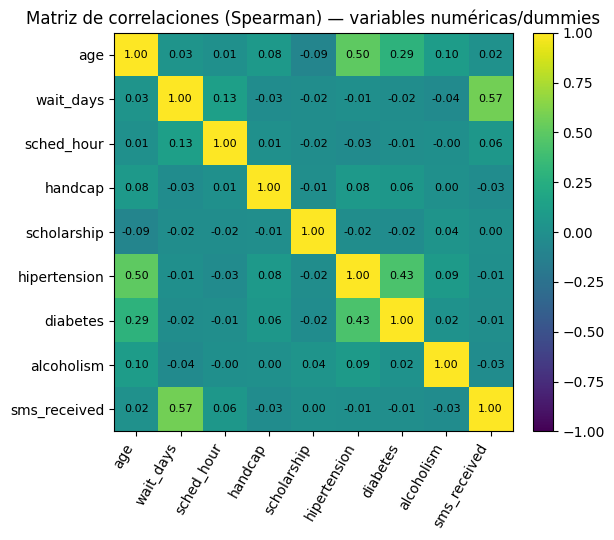

In [ ]:
num_for_corr = ["age","wait_days","sched_hour","handcap",
                "scholarship","hipertension","diabetes","alcoholism","sms_received"]

corr = df_modelo[num_for_corr].corr(method="spearman")

plt.figure(figsize=(6.5,5.5))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_for_corr)), num_for_corr, rotation=60, ha="right")
plt.yticks(range(len(num_for_corr)), num_for_corr)

# anotar valores
for (i, j), v in np.ndenumerate(corr.values):
    plt.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8)

plt.title("Matriz de correlaciones (Spearman) — variables numéricas/dummies")
plt.tight_layout()
plt.show()


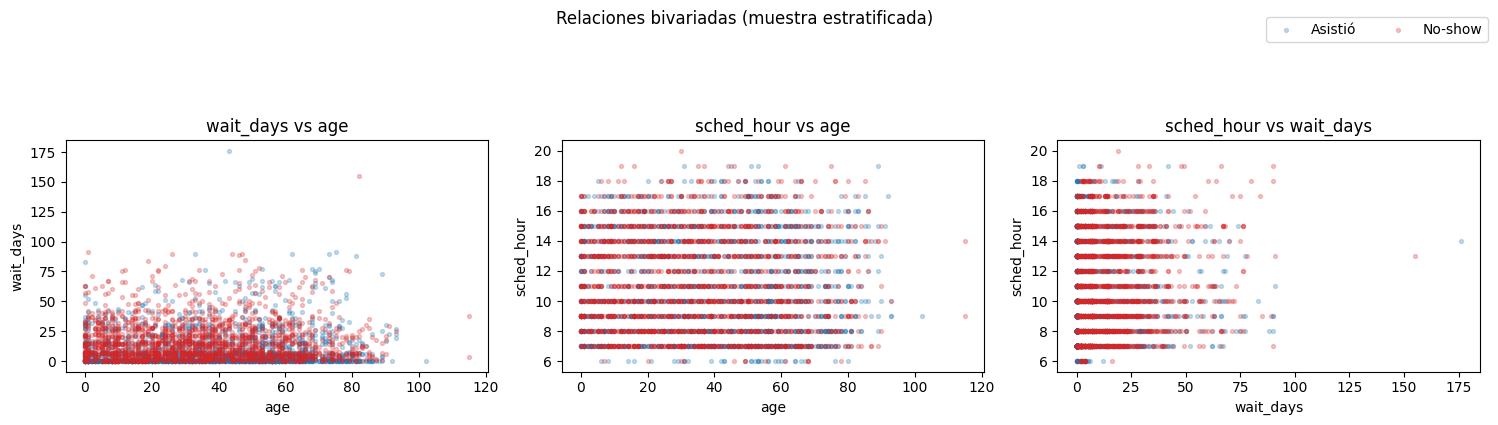

In [ ]:
# Submuestra estratificada
n_per_class = 2000
parts = []
for cls, g in df_modelo.groupby("no_show"):
    take = min(n_per_class, len(g))
    parts.append(g.sample(n=take, random_state=42))
smpl = pd.concat(parts, axis=0)

pairs = [("age","wait_days"), ("age","sched_hour"), ("wait_days","sched_hour")]
colors = {0:"C0", 1:"C3"}

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, (x,y) in zip(axes, pairs):
    for cls, g in smpl.groupby("no_show"):
        ax.scatter(g[x], g[y], s=8, alpha=0.25, label=("Asistió" if cls==0 else "No-show"),
                   c=colors[cls])
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.set_title(f"{y} vs {x}")

# una sola leyenda
handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, loc="upper right", ncol=2, bbox_to_anchor=(1.0, 1.05))

fig.suptitle("Relaciones bivariadas (muestra estratificada)", y=1.05)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


/tmp/ipython-input-1951423568.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g_day = DF.groupby("appt_weekday")["no_show"].agg(rate="mean", n="size").reset_index()


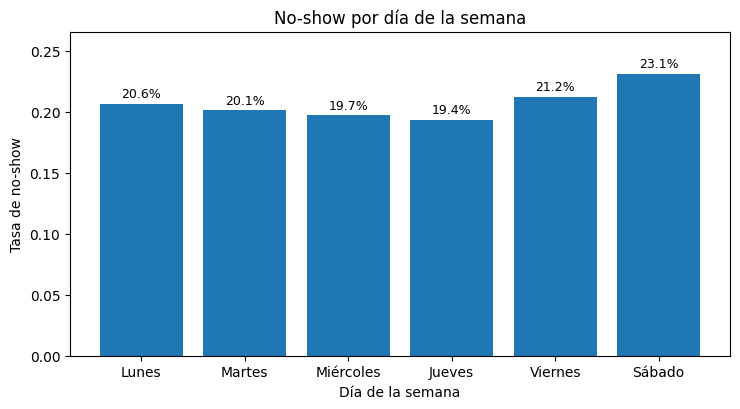

In [ ]:
# Figuras: tasas de no-show por día y por SMS
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ataFrame limpio:
try:
    DF = df_modelo.copy()
except NameError:
    DF = df.copy()


if "appt_weekday" not in DF.columns and "appointmentday" in DF.columns:
    DF["appointmentday"] = pd.to_datetime(DF["appointmentday"], errors="coerce")
    DF["appt_weekday"]   = DF["appointmentday"].dt.day_name()


os.makedirs("figs", exist_ok=True)

# Tasa de no-show por día de la semana
weekday_order_en = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_map_es   = {
    "Monday":"Lunes","Tuesday":"Martes","Wednesday":"Miércoles",
    "Thursday":"Jueves","Friday":"Viernes","Saturday":"Sábado","Sunday":"Domingo"
}

# Orden categórico
DF["appt_weekday"] = pd.Categorical(DF["appt_weekday"], categories=weekday_order_en, ordered=True)

g_day = DF.groupby("appt_weekday")["no_show"].agg(rate="mean", n="size").reset_index()
g_day = g_day.dropna(subset=["appt_weekday"])  # por si hay NaN
g_day["weekday_es"] = g_day["appt_weekday"].map(weekday_map_es)
g_day["rate_pct"]   = 100*g_day["rate"]

plt.figure(figsize=(7.5,4.2))
plt.bar(g_day["weekday_es"], g_day["rate"])
plt.ylabel("Tasa de no-show")
plt.xlabel("Día de la semana")
plt.title("No-show por día de la semana")
# Etiquetas arriba de cada barra (en %)
for x,y,n in zip(g_day["weekday_es"], g_day["rate"], g_day["n"]):
    plt.text(x, y+0.003, f"{y*100:.1f}%", ha="center", va="bottom", fontsize=9)
plt.ylim(0, max(g_day["rate"])*1.15)
plt.tight_layout()
plt.savefig("figs/fig_no_show_por_dia.png", dpi=200, bbox_inches="tight")
plt.show()

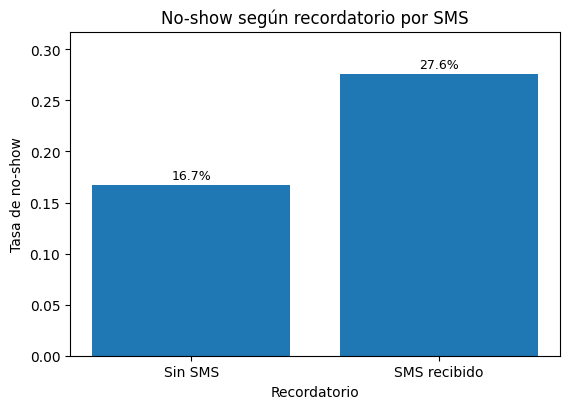

In [ ]:
# Tasa de no-show según SMS recibido
if "sms_received" not in DF.columns and "sms" in DF.columns:
    DF = DF.rename(columns={"sms":"sms_received"})

g_sms = DF.groupby("sms_received")["no_show"].agg(rate="mean", n="size").reset_index()
g_sms["grupo"] = g_sms["sms_received"].map({0:"Sin SMS", 1:"SMS recibido"})
g_sms = g_sms.sort_values("sms_received")
g_sms["rate_pct"] = 100*g_sms["rate"]

plt.figure(figsize=(5.8,4.2))
plt.bar(g_sms["grupo"], g_sms["rate"])
plt.ylabel("Tasa de no-show")
plt.xlabel("Recordatorio")
plt.title("No-show según recordatorio por SMS")
for x,y,n in zip(g_sms["grupo"], g_sms["rate"], g_sms["n"]):
    plt.text(x, y+0.003, f"{y*100:.1f}%", ha="center", va="bottom", fontsize=9)
plt.ylim(0, max(g_sms["rate"])*1.15)
plt.tight_layout()
plt.savefig("figs/fig_no_show_por_sms.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
#6A) Split estratificado y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Features y target
X = df_modelo.drop(columns=["no_show"])
y = df_modelo["no_show"]

# Split estratificado
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Columnas por tipo
cat = ["gender","neighbourhood","appt_weekday"]
num = ["age","scholarship","hipertension","diabetes","alcoholism","handcap",
       "sms_received","wait_days","sched_hour"]

# Preprocesador: OneHot en categóricas; numéricas pasan tal cual (salida densa)
try:
    # scikit-learn >= 1.2
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    # scikit-learn < 1.2
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[("cat", ohe, cat)],
    remainder="passthrough"
)


X_tr.shape, X_te.shape, y_tr.mean(), y_te.mean()


((88420, 12),
 (22106, 12),
 np.float64(0.20193395159466185),
 np.float64(0.2019361259386592))

In [ ]:
from scipy import sparse
Xt_sample = pre.fit_transform(X_tr)
print("¿Sparse?:", sparse.issparse(Xt_sample))


¿Sparse?: False


In [ ]:
#6B) Modelos: Logística y Random Forest + CV en el set de entrenamiento
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

# Modelos
logreg = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

rf = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=20,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])

# Validación cruzada 5-fold en TRAIN
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["roc_auc", "average_precision"]  # AP = area bajo PR

cv_lr = cross_validate(logreg, X_tr, y_tr, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
cv_rf = cross_validate(rf,     X_tr, y_tr, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

def resumir_cv(nombre, cvres):
    return {
        "modelo": nombre,
        "AUC_CV_mean": np.mean(cvres["test_roc_auc"]),
        "AUC_CV_sd":   np.std(cvres["test_roc_auc"], ddof=1),
        "AP_CV_mean":  np.mean(cvres["test_average_precision"]),
        "AP_CV_sd":    np.std(cvres["test_average_precision"], ddof=1)
    }

cv_summary = pd.DataFrame([resumir_cv("LogReg", cv_lr), resumir_cv("RandomForest", cv_rf)])
cv_summary


,modelo,AUC_CV_mean,AUC_CV_sd,AP_CV_mean,AP_CV_sd
0,LogReg,0.670373,0.005233,0.306486,0.004356
1,RandomForest,0.735522,0.005172,0.370479,0.004354


In [ ]:
# 6C) Entrena en TRAIN y evalúa en TEST (AUC, AP, precision@k)
from sklearn.metrics import roc_auc_score, average_precision_score

# Entrenamiento final
logreg.fit(X_tr, y_tr)
rf.fit(X_tr, y_tr)

# Probabilidades en test
p_lr = logreg.predict_proba(X_te)[:,1]
p_rf = rf.predict_proba(X_te)[:,1]

# Métricas
def precision_at_k(y_true, y_score, k=0.10):
    if isinstance(k, float):
        k = int(np.ceil(len(y_true) * k))
    idx = np.argsort(-y_score)[:k]
    return float(y_true.iloc[idx].mean())

results_test = pd.DataFrame([
    {
        "modelo": "LogReg",
        "AUC_test": roc_auc_score(y_te, p_lr),
        "AP_test":  average_precision_score(y_te, p_lr),
        "P@10%":    precision_at_k(y_te, p_lr, 0.10),
        "P@20%":    precision_at_k(y_te, p_lr, 0.20),
    },
    {
        "modelo": "RandomForest",
        "AUC_test": roc_auc_score(y_te, p_rf),
        "AP_test":  average_precision_score(y_te, p_rf),
        "P@10%":    precision_at_k(y_te, p_rf, 0.10),
        "P@20%":    precision_at_k(y_te, p_rf, 0.20),
    }
])
results_test


,modelo,AUC_test,AP_test,P@10%,P@20%
0,LogReg,0.673518,0.309706,0.356400,0.344640
1,RandomForest,0.737887,0.372396,0.418363,0.385346


In [ ]:
base = y_te.mean()
lift10_lr = results_test.loc[results_test["modelo"]=="LogReg", "P@10%"].item() / base
lift10_rf = results_test.loc[results_test["modelo"]=="RandomForest", "P@10%"].item() / base
print(f"Prevalencia (azar): {base:.3f} | Lift@10% LogReg: {lift10_lr:.2f}x | RF: {lift10_rf:.2f}x")


Prevalencia (azar): 0.202 | Lift@10% LogReg: 1.76x | RF: 2.07x


In [ ]:
# Obtener nombres de columnas tras el preprocesamiento
ohe = pre.named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(["gender","neighbourhood","appt_weekday"])
feat_names = np.r_[cat_names,
                   ["age","scholarship","hipertension","diabetes","alcoholism",
                    "handcap","sms_received","wait_days","sched_hour"]]
print("Total features transformadas:", len(feat_names))



Total features transformadas: 98


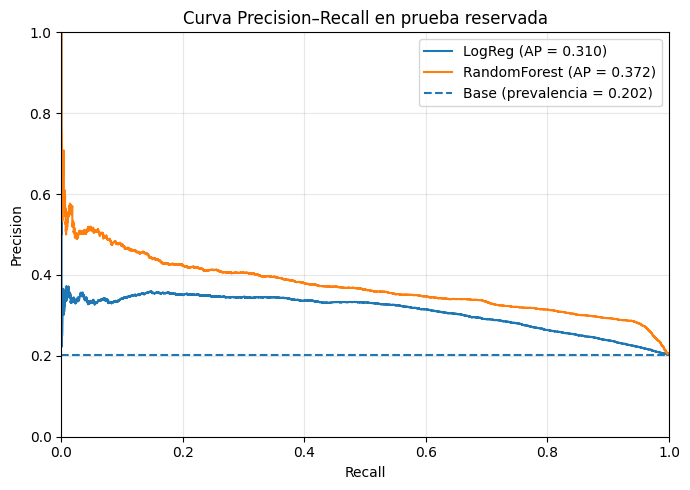

Gains@10% (recall top-10%): LogReg=0.177 | RF=0.207
Gains@20% (recall top-20%): LogReg=0.341 | RF=0.382


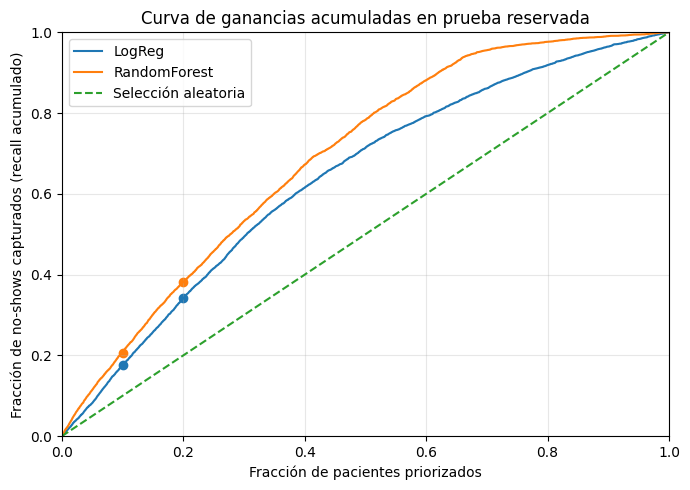

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Asegurar arrays 1D
y_true = np.asarray(y_te).astype(int)
p_lr_ = np.asarray(p_lr)
p_rf_ = np.asarray(p_rf)

# (A) PR curve (test)

prec_lr, rec_lr, _ = precision_recall_curve(y_true, p_lr_)
prec_rf, rec_rf, _ = precision_recall_curve(y_true, p_rf_)

ap_lr = average_precision_score(y_true, p_lr_)
ap_rf = average_precision_score(y_true, p_rf_)

base = y_true.mean()  # prevalencia en test

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(rec_lr, prec_lr, label=f"LogReg (AP = {ap_lr:.3f})")
ax.plot(rec_rf, prec_rf, label=f"RandomForest (AP = {ap_rf:.3f})")
ax.hlines(base, 0, 1, linestyles="--", label=f"Base (prevalencia = {base:.3f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Curva Precision–Recall en prueba reservada")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig_pr_test.png", dpi=300, bbox_inches="tight")
plt.show()

# (B) Gains curve (test)

def gains_curve(y, score):
    y = np.asarray(y).astype(int)
    score = np.asarray(score)
    order = np.argsort(-score)
    y_sorted = y[order]
    cum_tp = np.cumsum(y_sorted)
    total_tp = cum_tp[-1]
    frac_pop = np.arange(1, len(y) + 1) / len(y)
    gain = cum_tp / total_tp
    # incluir (0,0) para que arranque en el origen
    frac_pop = np.r_[0.0, frac_pop]
    gain = np.r_[0.0, gain]
    return frac_pop, gain

def gain_at_k(frac_pop, gain, k):
    # k en [0,1]
    idx = np.searchsorted(frac_pop, k, side="left")
    idx = min(idx, len(gain)-1)
    return float(gain[idx])

x_lr, g_lr = gains_curve(y_true, p_lr_)
x_rf, g_rf = gains_curve(y_true, p_rf_)

g10_lr = gain_at_k(x_lr, g_lr, 0.10)
g10_rf = gain_at_k(x_rf, g_rf, 0.10)
g20_lr = gain_at_k(x_lr, g_lr, 0.20)
g20_rf = gain_at_k(x_rf, g_rf, 0.20)

print(f"Gains@10% (recall top-10%): LogReg={g10_lr:.3f} | RF={g10_rf:.3f}")
print(f"Gains@20% (recall top-20%): LogReg={g20_lr:.3f} | RF={g20_rf:.3f}")

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x_lr, g_lr, label="LogReg")
ax.plot(x_rf, g_rf, label="RandomForest")
ax.plot([0, 1], [0, 1], linestyle="--", label="Selección aleatoria")

# marcadores en 10% y 20%
ax.scatter([0.10, 0.20], [g10_lr, g20_lr])
ax.scatter([0.10, 0.20], [g10_rf, g20_rf])

ax.set_xlabel("Fracción de pacientes priorizados")
ax.set_ylabel("Fracción de no-shows capturados (recall acumulado)")
ax.set_title("Curva de ganancias acumuladas en prueba reservada")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig_gains_test.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# 6D) Endogeneidad SMS: estimar p0(X)=P(Y=1 | X, D=0) con IPW
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# X_tr, X_te, y_tr, y_te existen de 6A
# D = sms_received (tratamiento histórico)
D_tr = X_tr["sms_received"].astype(int).values
D_te = X_te["sms_received"].astype(int).values

# Covariables pre-tratamiento: EXCLUIMOS sms_received
X0_tr = X_tr.drop(columns=["sms_received"])
X0_te = X_te.drop(columns=["sms_received"])

cat0 = ["gender", "neighbourhood", "appt_weekday"]

# OneHot robusto (salida densa)
try:
    ohe0 = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe0 = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre0 = ColumnTransformer(
    transformers=[("cat", ohe0, cat0)],
    remainder="passthrough"
)

In [ ]:
# Propensity score e(X)=P(D=1|X)
ps_model = Pipeline([
    ("pre", pre0),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
ps_model.fit(X0_tr, D_tr)

e_tr = ps_model.predict_proba(X0_tr)[:, 1]

# Overlap: recortar para evitar pesos infinitos
eps = 1e-3
e_tr = np.clip(e_tr, eps, 1 - eps)

# Pesos IPW para el grupo D=0: w = 1 / P(D=0|X) = 1/(1-e)
mask0_tr = (D_tr == 0)
w0_tr = 1.0 / (1.0 - e_tr[mask0_tr])

# Cap de pesos para estabilidad (winsorización)
cap = np.quantile(w0_tr, 0.99)   # o cap = 20
w0_tr_cap = np.minimum(w0_tr, cap)

ess_cap = (w0_tr_cap.sum()**2) / np.sum(w0_tr_cap**2)
print("Cap =", cap)
print("ESS cap:", int(ess_cap), "de", int(mask0_tr.sum()))
print("max w antes:", w0_tr.max(), "| max w cap:", w0_tr_cap.max())


print("Train: share D=1 (SMS):", D_tr.mean().round(3))
print("Pesos IPW (solo D=0): min/median/p95/max =",
      np.min(w0_tr), np.median(w0_tr), np.quantile(w0_tr, 0.95), np.max(w0_tr))

Cap = 51.73598111782874
ESS cap: 10485 de 60126
max w antes: 999.9999999999991 | max w cap: 51.73598111782874
Train: share D=1 (SMS): 0.32
Pesos IPW (solo D=0): min/median/p95/max = 1.0660688756574936 1.483154215288553 6.163077966574372 999.9999999999991


In [ ]:
# tamaño efectivo (si es muy bajo, overlap débil)
ess = (w0_tr.sum()**2) / (np.sum(w0_tr**2))
print("Effective sample size (D=0, ponderado):", int(ess), "de", int(mask0_tr.sum()))

Effective sample size (D=0, ponderado): 920 de 60126


In [ ]:
# (2) Modelo de política: entrenar SOLO en D=0 con sample_weight
y_te_np = np.asarray(y_te).astype(int)

X_pol = X0_tr.loc[mask0_tr]
y_pol = y_tr_np[mask0_tr]

# (A) Política con Logística
pol_logit = Pipeline([
    ("pre", pre0),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
pol_logit.fit(X_pol, y_pol, clf__sample_weight=w0_tr_cap)

# (B) Política con RandomForest
pol_rf = Pipeline([
    ("pre", pre0),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=20,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])
pol_rf.fit(X_pol, y_pol, clf__sample_weight=w0_tr_cap)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'neighbourhood',
                                                   'appt_weekday'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=20, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# (3) Predicción p0_hat(X) para todos (no usa sms_received)
p0_rf = pol_rf.predict_proba(X0_te)[:, 1]

# (4) Evaluación CORRECTA en test sobre el grupo D=0 (observamos Y|D=0)
mask0_te = (D_te == 0)
y0_te = y_te_np[mask0_te]
p0_lr_te = p0_lr[mask0_te]
p0_rf_te = p0_rf[mask0_te]

def precision_at_k_np(y_true, y_score, k=0.10):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    if isinstance(k, float):
        k = int(np.ceil(len(y_true) * k))
    idx = np.argsort(-y_score)[:k]
    return float(y_true[idx].mean())

base0 = y0_te.mean()

policy_results = pd.DataFrame([
    {
        "modelo": "Policy-LogReg (p0)",
        "N_test_D0": int(mask0_te.sum()),
        "prev_D0_test": base0,
        "AUC_test_D0": roc_auc_score(y0_te, p0_lr_te),
        "AP_test_D0":  average_precision_score(y0_te, p0_lr_te),
        "P@10%_D0":    precision_at_k_np(y0_te, p0_lr_te, 0.10),
        "P@20%_D0":    precision_at_k_np(y0_te, p0_lr_te, 0.20),
    },
    {
        "modelo": "Policy-RF (p0)",
        "N_test_D0": int(mask0_te.sum()),
        "prev_D0_test": base0,
        "AUC_test_D0": roc_auc_score(y0_te, p0_rf_te),
        "AP_test_D0":  average_precision_score(y0_te, p0_rf_te),
        "P@10%_D0":    precision_at_k_np(y0_te, p0_rf_te, 0.10),
        "P@20%_D0":    precision_at_k_np(y0_te, p0_rf_te, 0.20),
    }
])

policy_results["Lift@10%_D0"] = policy_results["P@10%_D0"] / policy_results["prev_D0_test"]
policy_results["Lift@20%_D0"] = policy_results["P@20%_D0"] / policy_results["prev_D0_test"]

policy_results

,modelo,N_test_D0,prev_D0_test,AUC_test_D0,AP_test_D0,P@10%_D0,P@20%_D0,Lift@10%_D0,Lift@20%_D0
0,Policy-LogReg (p0),14918,0.164365,0.640936,0.270909,0.357239,0.296247,2.173444,1.802368
1,Policy-RF (p0),14918,0.164365,0.783140,0.372171,0.424933,0.375670,2.585298,2.285583


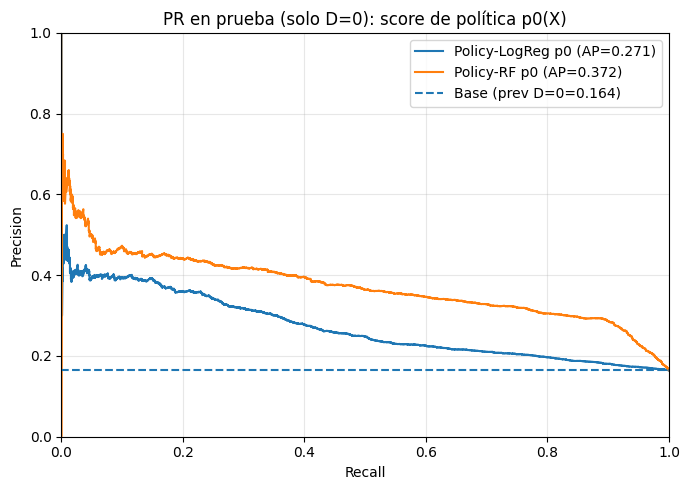

Policy gains@10%: LogReg=0.217 | RF=0.259
Policy gains@20%: LogReg=0.361 | RF=0.457


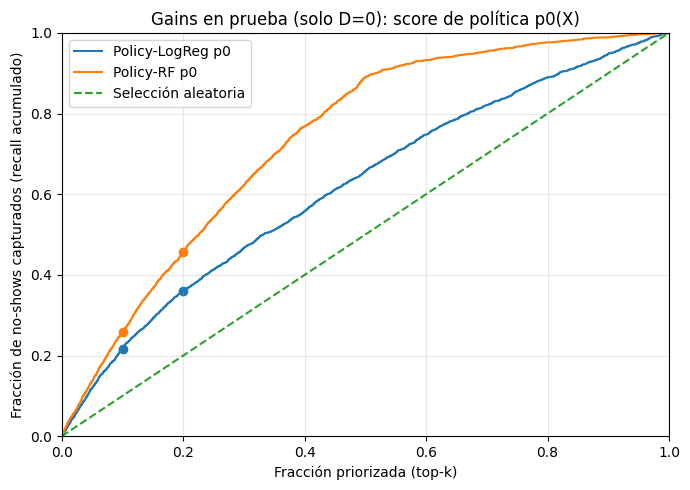

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Arrays
y_pol_te = np.asarray(y0_te).astype(int)
s_lr = np.asarray(p0_lr_te)
s_rf = np.asarray(p0_rf_te)

base = y_pol_te.mean()

# (A) PR curve (Policy, D=0 test)
prec_lr, rec_lr, _ = precision_recall_curve(y_pol_te, s_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_pol_te, s_rf)

ap_lr = average_precision_score(y_pol_te, s_lr)
ap_rf = average_precision_score(y_pol_te, s_rf)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(rec_lr, prec_lr, label=f"Policy-LogReg p0 (AP={ap_lr:.3f})")
ax.plot(rec_rf, prec_rf, label=f"Policy-RF p0 (AP={ap_rf:.3f})")
ax.hlines(base, 0, 1, linestyles="--", label=f"Base (prev D=0={base:.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR en prueba (solo D=0): score de política p0(X)")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("fig_pr_policy_p0_D0test.png", dpi=300, bbox_inches="tight")
plt.show()

# (B) Gains curve (Policy, D=0 test)
def gains_curve(y, score):
    y = np.asarray(y).astype(int)
    score = np.asarray(score)
    order = np.argsort(-score)
    y_sorted = y[order]
    cum_tp = np.cumsum(y_sorted)
    total_tp = cum_tp[-1]
    frac_pop = np.arange(1, len(y) + 1) / len(y)
    gain = cum_tp / total_tp
    return np.r_[0.0, frac_pop], np.r_[0.0, gain]

def gain_at_k(frac_pop, gain, k):
    idx = np.searchsorted(frac_pop, k, side="left")
    idx = min(idx, len(gain)-1)
    return float(gain[idx])

x_lr, g_lr = gains_curve(y_pol_te, s_lr)
x_rf, g_rf = gains_curve(y_pol_te, s_rf)

g10_lr = gain_at_k(x_lr, g_lr, 0.10)
g10_rf = gain_at_k(x_rf, g_rf, 0.10)
g20_lr = gain_at_k(x_lr, g_lr, 0.20)
g20_rf = gain_at_k(x_rf, g_rf, 0.20)

print(f"Policy gains@10%: LogReg={g10_lr:.3f} | RF={g10_rf:.3f}")
print(f"Policy gains@20%: LogReg={g20_lr:.3f} | RF={g20_rf:.3f}")

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_lr, g_lr, label="Policy-LogReg p0")
ax.plot(x_rf, g_rf, label="Policy-RF p0")
ax.plot([0,1],[0,1], linestyle="--", label="Selección aleatoria")
ax.scatter([0.10, 0.20], [g10_lr, g20_lr])
ax.scatter([0.10, 0.20], [g10_rf, g20_rf])
ax.set_xlabel("Fracción priorizada (top-k)")
ax.set_ylabel("Fracción de no-shows capturados (recall acumulado)")
ax.set_title("Gains en prueba (solo D=0): score de política p0(X)")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("fig_gains_policy_p0_D0test.png", dpi=300, bbox_inches="tight")
plt.show()


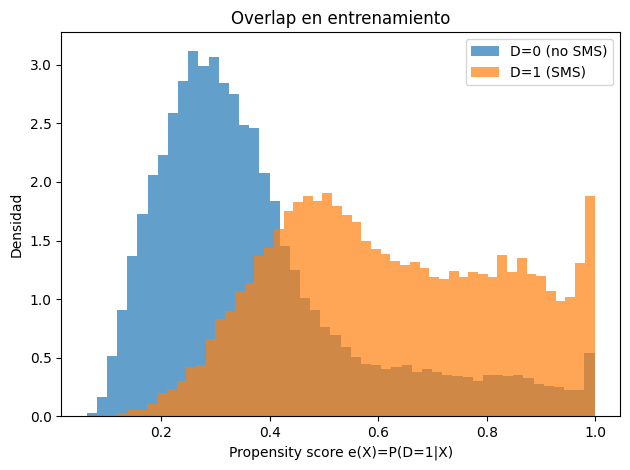

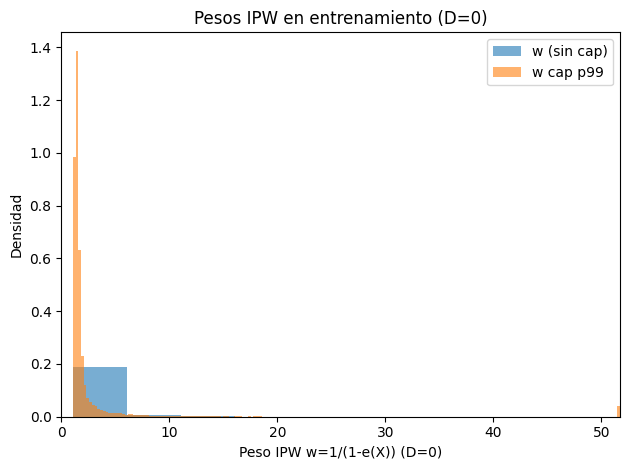

ESS sin cap: 920 de 60126
ESS cap p99: 10485 de 60126


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Overlap: distribución de e(X) por grupo D en TRAIN
e_tr_full = ps_model.predict_proba(X0_tr)[:, 1]
e_tr_full = np.clip(e_tr_full, 1e-3, 1-1e-3)

plt.figure()
plt.hist(e_tr_full[D_tr==0], bins=50, alpha=0.7, density=True, label="D=0 (no SMS)")
plt.hist(e_tr_full[D_tr==1], bins=50, alpha=0.7, density=True, label="D=1 (SMS)")
plt.xlabel("Propensity score e(X)=P(D=1|X)")
plt.ylabel("Densidad")
plt.title("Overlap en entrenamiento")
plt.legend()
plt.tight_layout()
plt.savefig("fig_propensity_overlap.png", dpi=200)
plt.show()

# Distribución de pesos w(X) en D=0 (sin cap vs cap)
plt.figure()
plt.hist(w0_tr, bins=200, alpha=0.6, density=True, label="w (sin cap)")
plt.hist(w0_tr_cap, bins=200, alpha=0.6, density=True, label="w cap p99")
plt.xlim(0, np.quantile(w0_tr_cap, 0.995))
plt.xlabel("Peso IPW w=1/(1-e(X)) (D=0)")
plt.ylabel("Densidad")
plt.title("Pesos IPW en entrenamiento (D=0)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_ipw_weights.png", dpi=200)
plt.show()

# Reporte ESS
def ess(weights):
    w = np.asarray(weights)
    return (w.sum()**2) / np.sum(w**2)

print("ESS sin cap:", int(ess(w0_tr)), "de", int(mask0_tr.sum()))
print("ESS cap p99:", int(ess(w0_tr_cap)), "de", int(mask0_tr.sum()))


In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score

def fit_policy_models_with_cap(cap_rule):
    # cap_rule: None, ("quantile", 0.99), ("quantile", 0.95), ("fixed", 20.0)
    e_tr = ps_model.predict_proba(X0_tr)[:, 1]
    e_tr = np.clip(e_tr, 1e-3, 1-1e-3)

    w0 = 1.0 / (1.0 - e_tr[mask0_tr])

    if cap_rule is None:
        w0_use = w0
        cap_label = "none"
    else:
        kind, val = cap_rule
        if kind == "quantile":
            capv = np.quantile(w0, val)
            w0_use = np.minimum(w0, capv)
            cap_label = f"p{int(val*100)}"
        elif kind == "fixed":
            w0_use = np.minimum(w0, float(val))
            cap_label = f"{val:g}"
        else:
            raise ValueError("cap_rule desconocida")

    # entrenar en D=0
    X_pol = X0_tr.loc[mask0_tr]
    y_pol = np.asarray(y_tr).astype(int)[mask0_tr]

    pol_logit = Pipeline([("pre", pre0),
                          ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
    pol_rf = Pipeline([("pre", pre0),
                       ("clf", RandomForestClassifier(
                           n_estimators=300, min_samples_leaf=20,
                           class_weight="balanced_subsample",
                           random_state=42, n_jobs=-1
                       ))])

    pol_logit.fit(X_pol, y_pol, clf__sample_weight=w0_use)
    pol_rf.fit(X_pol, y_pol, clf__sample_weight=w0_use)

    # predicción y evaluación en D=0 test
    p_lr = pol_logit.predict_proba(X0_te)[:, 1][mask0_te]
    p_rf = pol_rf.predict_proba(X0_te)[:, 1][mask0_te]
    y0   = np.asarray(y_te).astype(int)[mask0_te]

    def p_at_k(y_true, y_score, frac):
        k = int(np.ceil(len(y_true)*frac))
        idx = np.argsort(-y_score)[:k]
        return float(y_true[idx].mean())

    out = []
    for name, p in [("Policy-LogReg", p_lr), ("Policy-RF", p_rf)]:
        out.append({
            "modelo": name,
            "cap": cap_label,
            "AUC_D0": roc_auc_score(y0, p),
            "AP_D0": average_precision_score(y0, p),
            "P@10%_D0": p_at_k(y0, p, 0.10),
            "P@20%_D0": p_at_k(y0, p, 0.20),
            "prev_D0": float(y0.mean())
        })
    return pd.DataFrame(out)

sens = pd.concat([
    fit_policy_models_with_cap(None),
    fit_policy_models_with_cap(("quantile", 0.95)),
    fit_policy_models_with_cap(("quantile", 0.99)),
    fit_policy_models_with_cap(("fixed", 20.0)),
], ignore_index=True)

sens["Lift@10%_D0"] = sens["P@10%_D0"] / sens["prev_D0"]
sens["Lift@20%_D0"] = sens["P@20%_D0"] / sens["prev_D0"]
sens.sort_values(["modelo","cap"])


,modelo,cap,AUC_D0,AP_D0,P@10%_D0,P@20%_D0,prev_D0,Lift@10%_D0,Lift@20%_D0
6,Policy-LogReg,20,0.664349,0.287594,0.382708,0.322386,0.164365,2.328399,1.961401
0,Policy-LogReg,none,0.554020,0.194075,0.227212,0.207105,0.164365,1.382360,1.260027
2,Policy-LogReg,p95,0.688256,0.299014,0.384048,0.341488,0.164365,2.336555,2.077617
4,Policy-LogReg,p99,0.640936,0.270909,0.357239,0.296247,0.164365,2.173444,1.802368
7,Policy-RF,20,0.784481,0.377168,0.424263,0.382708,0.164365,2.581220,2.328399
1,Policy-RF,none,0.778437,0.360863,0.417560,0.368633,0.164365,2.540442,2.242766
3,Policy-RF,p95,0.785110,0.376817,0.424933,0.378351,0.164365,2.585298,2.301894
5,Policy-RF,p99,0.783140,0.372171,0.424933,0.375670,0.164365,2.585298,2.285583


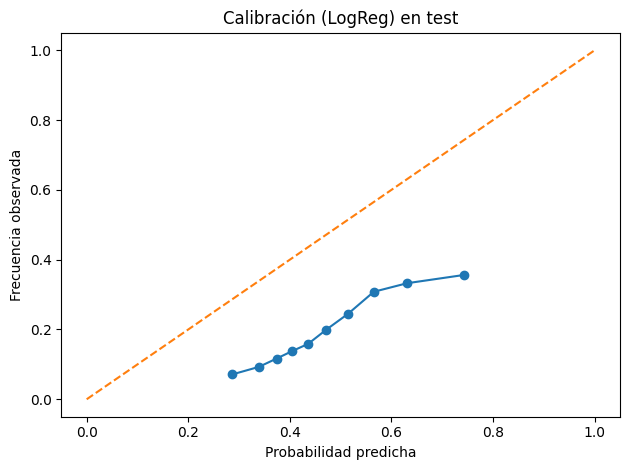

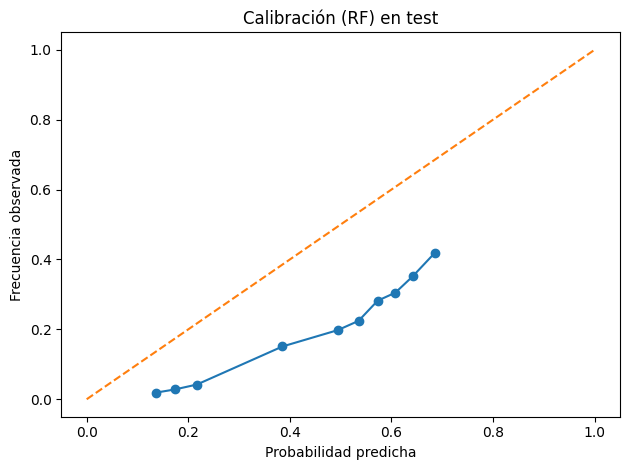

Brier LogReg: 0.22946604480896127
Brier RF    : 0.20669889618002185


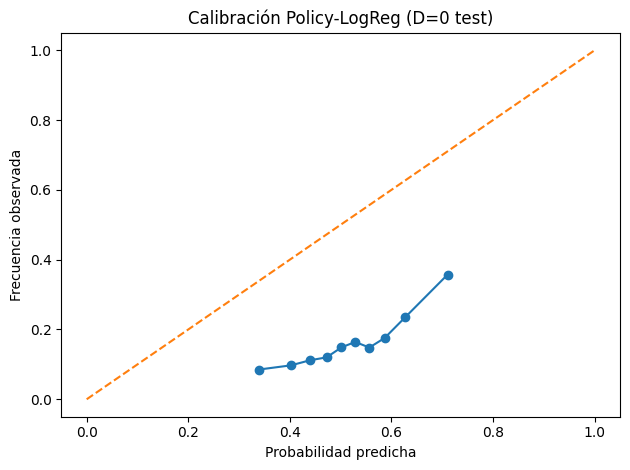

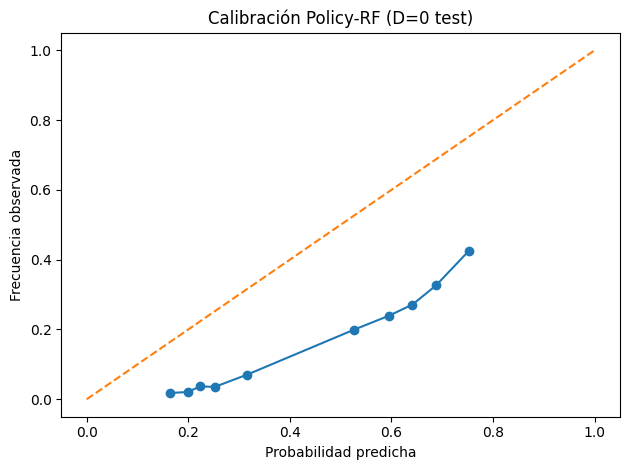

Brier Policy-LogReg: 0.2575619490409513
Brier Policy-RF    : 0.19807987302218105


In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import numpy as np

def plot_calibration(y_true, p_score, title, fname, n_bins=10):
    frac_pos, mean_pred = calibration_curve(y_true, p_score, n_bins=n_bins, strategy="quantile")

    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("Probabilidad predicha")
    plt.ylabel("Frecuencia observada")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

# Calibración modelo principal (test completo)
y_test = np.asarray(y_te).astype(int)
plot_calibration(y_test, p_lr, "Calibración (LogReg) en test", "fig_calibration_test_logreg.png")
plot_calibration(y_test, p_rf, "Calibración (RF) en test", "fig_calibration_test_rf.png")

print("Brier LogReg:", brier_score_loss(y_test, p_lr))
print("Brier RF    :", brier_score_loss(y_test, p_rf))

# Calibración score de política (test restringido a D=0)
y0_te = np.asarray(y_te).astype(int)[mask0_te]
plot_calibration(y0_te, p0_lr_te, "Calibración Policy-LogReg (D=0 test)", "fig_calibration_policy_logreg.png")
plot_calibration(y0_te, p0_rf_te, "Calibración Policy-RF (D=0 test)", "fig_calibration_policy_rf.png")

print("Brier Policy-LogReg:", brier_score_loss(y0_te, p0_lr_te))
print("Brier Policy-RF    :", brier_score_loss(y0_te, p0_rf_te))


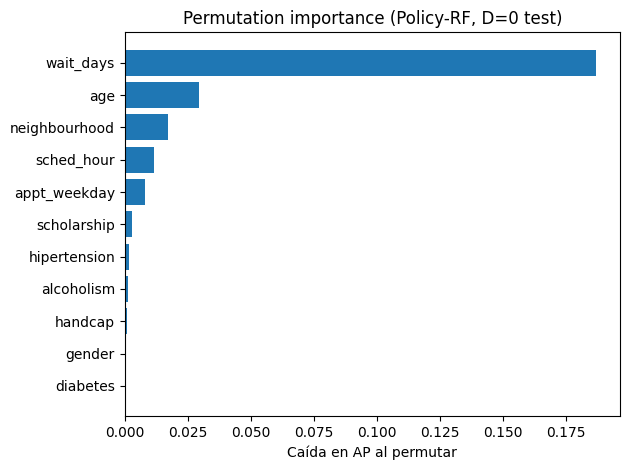

,feature,importance_mean,importance_sd
8,wait_days,0.187017,0.003390
0,age,0.029502,0.004247
2,neighbourhood,0.017082,0.003449
10,sched_hour,0.011805,0.001888
9,appt_weekday,0.007977,0.002763
3,scholarship,0.002800,0.001175
4,hipertension,0.001630,0.002044
6,alcoholism,0.001186,0.000396
7,handcap,0.000868,0.000668
1,gender,0.000398,0.001279


In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Permutation importance en D=0 test para Policy-RF
X_eval = X0_te.loc[mask0_te]
y_eval = np.asarray(y_te).astype(int)[mask0_te]

perm = permutation_importance(
    pol_rf, X_eval, y_eval,
    scoring="average_precision",
    n_repeats=10, random_state=42, n_jobs=-1
)

imp = pd.DataFrame({
    "feature": X_eval.columns,
    "importance_mean": perm.importances_mean,
    "importance_sd": perm.importances_std
}).sort_values("importance_mean", ascending=False)

top = imp.head(15).iloc[::-1]  # para barh
plt.figure()
plt.barh(top["feature"], top["importance_mean"])
plt.xlabel("Caída en AP al permutar")
plt.title("Permutation importance (Policy-RF, D=0 test)")
plt.tight_layout()
plt.savefig("fig_perm_importance_policy_rf.png", dpi=200)
plt.show()

imp.head(20)
